![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Machine Learning for Finance - Assignment 1

### by Amber Walker and Clarice Mottet
### All work was distributed and completed equally.

0. **[Part 0: Set Up and Import](#part0)**
- **Objective**: Initialize programming environment and data.
- **Tasks:**
  - Initialize libraries.
  - Import data into the programming environment.
  - Conduct preprocessing.

1. **[Part 1: EWMA Based Variance](#part1)**
- **Objective**: Compare two models to calculate EWMA Based Variance
- **Tasks:**
  - EWMA Equation: Use the equation covered in class to calculate EWMA based variance.
  - EWMA Recursion: Use the recursive formula definition to calculate EWMA based variance.
  - Compare the two methods to calculate EWMA based variance.

2. **[Part 2: Causality Analysis](#part2)**
- **Objective**: Conduct causality analysis with multiple lag variables and time frame windows.
- **Tasks:**
  - task list here

3. **[Part 3: Modeling](#part3)**
- **Objective**: Create a neural network and a gaussian process regression to model return, price, or direction (up or down).
- **Tasks:**
  - (I think we should predict a binary outcome of the stock direction goes up or down personally)
  - Feature creation: Create multiple types of lag variables for different lag amounts.
  - Feature selection: (I'd suggest a good old random forest cause I personally love a random forest feature selection or an XGBoost feature selection).
  - Create a neural network, discuss hyper parameter tuning.
  - Create a gaussian process, discuss hyper parameter tuning.

4. **[Part 4: Further Analysis](#part4)**
- **Objective**: Discuss modeling aspects and compare methods.
- **Tasks:**
  - Create an ARMA model and compare to the neural network and gaussian process.
  - Discuss if bootstrapping would aid model performance and efficacy and what modeling would look like with the incorporation of stationary bootstrapping.


## <a id='part0'>Part 0: Set Up and Import</a>
- **Objective**: Initialize programming environment and data.
- **Tasks:**
  - Initialize libraries.
  - Import data into the programming environment.
  - Conduct preprocessing.

In [ ]:
!pip install panelsplit > /dev/null # installation of PanelSplit
!pip3 install pmdarima
!pip3 install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 5.6 MB/s eta 0:00:00


In [1]:
#Libraries
import pandas as pd
import numpy as np
import os
import gc
import datetime
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from google.colab import drive
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel as C, RationalQuadratic, ExpSineSquared, RBF, Sum, Product, WhiteKernel, ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import precision_score, explained_variance_score, accuracy_score, classification_report, roc_auc_score, accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.neural_network import MLPRegressor, MLPClassifier
from panelsplit import PanelSplit
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels for statistical methods
import statsmodels.tsa.api as smt
from statsmodels.stats.diagnostic import het_arch
import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# scipy stats for shapiro test
from scipy import stats
from pmdarima.arima import auto_arima
from arch import arch_model

drive.mount('/content/drive')

#Paths
#path_in_ = r'/home/clarice/Documents/VSCode/Term3/ML_Finance/MLF_HW1/inputs/'
#path_out_ = r'/home/clarice/Documents/VSCode/Term3/ML_Finance/MLF_HW1/outputs/'
path_in_ = r'/content/drive/MyDrive/ML_Finance/MLF_HW1/inputs/'
path_out_ = r'/content/drive/MyDrive/ML_Finance/MLF_HW1/outputs/'

ModuleNotFoundError: No module named 'panelsplit'

In [ ]:
#Import

#using a text file we created from an R file
df_market = pd.read_csv(path_in_ + 'WorldMarkets99_20.txt', sep = '|', dtype = str)
df_market.columns = df_market.columns.str.lower().str.strip()
df_market[['open','high','low','close','volume','adjusted']] = df_market[['open','high','low','close','volume','adjusted']].apply(pd.to_numeric)
df_market['date'] = pd.to_datetime(df_market['date'])
df_market.sort_values(by = ['market','date'], inplace = True)
df_market.reset_index(drop = True, inplace = True)

df_market.describe()

,open,high,low,close,volume,adjusted,date
count,69035.000000,69035.000000,69035.000000,69035.000000,6.903500e+04,69035.000000,70078
mean,11464.128611,11555.368887,11366.426424,11462.595335,4.028610e+08,11462.588664,2009-08-02 18:18:57.361225984
min,9.010000,9.310000,8.560000,9.140000,0.000000e+00,9.140000,1999-01-04 00:00:00
25%,1891.545044,1907.417481,1872.669983,1890.239990,8.400000e+03,1890.239990,2004-03-19 00:00:00
50%,6737.540039,6785.109863,6682.490234,6733.229980,4.237800e+06,6733.204102,2009-07-21 00:00:00
75%,11869.479981,11951.899903,11773.080078,11867.850098,1.535236e+08,11867.850098,2014-12-09 00:00:00
max,119528.000000,119593.000000,118108.000000,119528.000000,1.145623e+10,119528.000000,2020-04-30 00:00:00
std,15447.245090,15581.477219,15309.464143,15448.944086,9.914707e+08,15448.946777,NaN


In [ ]:
# df_view = df_market[df_market['market']=='BSESN'].copy()
# df_view.to_excel(path_out_+'view_BSESN.xlsx')

It looks like missing information above corresponds to bank holidays, I would do a .ffill() grouped by the column 'market' to fill in null values with the previous date's available market close.

There are no weekend dates in the data, so I would add in dates that are missing and also do a .ffill() grouped by the column 'market' and also include in the data a one hot encoded field that is 1 for week day and 0 for weekend to account for this preprocessing. I think we're going to want all dates to build a model on.

.ffill() is a forward fill so that when you fill in missing information for a date, its filling in the missing information with the last previous day's information.

First, we fetch the data from 12/30/98 for each market and add it to our df so that we can .ffill() that data to the first missing values. There is no data for the 31st, so we get the data for the 30th.

In [ ]:
#fetch the data for 12/30/98
market_symbols = [
    "^BSESN", "^BVSP", "^FTSE", "^GDAXI", "^GSPC", "^HSCE",
    "^IBEX", "^JKSE", "^MXX", "^N225", "^TWII", "^VLIC", "^VIX"
]
market_countries = [
    "India", "Brazil", "UK", "Germany", "USA", "China-Shanghai",
    "Spain", "Indonesia", "Mexico", "Japan", "Taiwan", "VLIC", "VIX"
]

start_date = datetime.datetime(1998, 12, 30)
end_date = datetime.datetime(1998, 12, 31)

# Function to retrieve and store market data using yfinance
def get_market_data(symbols, start, end):
    data = {}
    for symbol in symbols:
        try:
            ticker = yf.Ticker(symbol)
            data[symbol] = ticker.history(start=start, end=end, auto_adjust=False)
        except Exception as e:
            print(f"Failed to retrieve data for {symbol}: {str(e)}")
    return data

def prepare_data_for_merge(day_before_data):
    all_data = []
    for symbol, df in day_before_data.items():
        if not df.empty:
            df['market'] = symbol  # Add a 'Symbol' column to each DataFrame
            all_data.append(df)
    combined_df = pd.concat(all_data)
    return combined_df

In [ ]:
#get market data
day_before_data = get_market_data(market_symbols, start_date, end_date)

# for symbol in market_symbols:
#   print(day_before_data[symbol])

combined_df = prepare_data_for_merge(day_before_data)

In [ ]:
combined_df.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,market,Capital Gains
Date,,,,,,,,,,
1998-12-30 00:00:00+05:30,3074.439941,3118.590088,3072.610107,3110.330078,3110.330078,0,0.0,0.0,^BSESN,NaN
1998-12-30 00:00:00-02:00,6715.000000,6865.000000,6712.000000,6784.000000,6784.000000,0,0.0,0.0,^BVSP,NaN
1998-12-30 00:00:00+00:00,5932.700195,5944.899902,5809.000000,5882.600098,5882.600098,0,0.0,0.0,^FTSE,NaN
1998-12-30 00:00:00+01:00,5054.859863,5089.229980,4999.709961,5006.569824,5006.569824,0,0.0,0.0,^GDAXI,NaN
1998-12-30 00:00:00-05:00,1241.810059,1244.930054,1231.199951,1231.930054,1231.930054,594220000,0.0,0.0,^GSPC,NaN


In [ ]:
#clean data
combined_df = combined_df.drop(columns=['Dividends', 'Stock Splits', 'Capital Gains'])
combined_df = combined_df.reset_index()
combined_df.rename(columns={'index': 'date'}, inplace=True)
combined_df.rename(columns={'Adj Close': 'adjusted'}, inplace=True)
combined_df.columns = combined_df.columns.str.lower()
combined_df['market'] = combined_df['market'].str.replace('^', '', regex=False)

#remove the timezone
if 'date' in combined_df.columns:
    combined_df['date'] = pd.to_datetime(combined_df['date'], utc=True)
    combined_df['date'] = combined_df['date'].dt.tz_localize(None)
    combined_df['date'] = combined_df['date'].dt.date

display(combined_df.head())

,date,open,high,low,close,adjusted,volume,market
0,1998-12-29,3074.439941,3118.590088,3072.610107,3110.330078,3110.330078,0,BSESN
1,1998-12-30,6715.000000,6865.000000,6712.000000,6784.000000,6784.000000,0,BVSP
2,1998-12-30,5932.700195,5944.899902,5809.000000,5882.600098,5882.600098,0,FTSE
3,1998-12-29,5054.859863,5089.229980,4999.709961,5006.569824,5006.569824,0,GDAXI
4,1998-12-30,1241.810059,1244.930054,1231.199951,1231.930054,1231.930054,594220000,GSPC


### Add missing dates

In [ ]:
#first we build a df with all dates (including weekends) for EACH market
start_date = datetime.datetime(1999, 1, 1)
end_date = datetime.datetime(2020, 4, 30)
#date range
dates = pd.date_range(start=start_date, end=end_date, freq='D')
#all of the diff markets
markets = df_market['market'].unique()
#df build
date_df = pd.DataFrame([(date, market) for market in markets for date in dates], columns=['date', 'market'])

print(date_df.head())


        date market
0 1999-01-01  BSESN
1 1999-01-02  BSESN
2 1999-01-03  BSESN
3 1999-01-04  BSESN
4 1999-01-05  BSESN


In [ ]:
#merge the market df onto the date_df, so all dates are included
df = date_df.merge(df_market, on=['date', 'market'], how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101283 entries, 0 to 101282
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      101283 non-null  datetime64[ns]
 1   market    101283 non-null  object        
 2   open      69035 non-null   float64       
 3   high      69035 non-null   float64       
 4   low       69035 non-null   float64       
 5   close     69035 non-null   float64       
 6   volume    69035 non-null   float64       
 7   adjusted  69035 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.2+ MB


In [ ]:
#add on the new data
combined_df['date'] = pd.to_datetime(combined_df['date'])
df['date'] = pd.to_datetime(df['date'])
df = pd.concat([df, combined_df], ignore_index=True).copy()
df = df.sort_values(by='date')

print(df.head())

             date market          open          high           low  \
101286 1998-12-29  GDAXI   5054.859863   5089.229980   4999.709961   
101293 1998-12-29   TWII   6545.779785   6566.549805   6433.450195   
101292 1998-12-29   N225  13832.320312  13913.549805  13812.870117   
101283 1998-12-29  BSESN   3074.439941   3118.590088   3072.610107   
101290 1998-12-29   JKSE    396.915985    398.037994    390.084015   

               close     volume      adjusted  
101286   5006.569824        0.0   5006.569824  
101293   6462.029785        0.0   6462.005371  
101292  13842.169922        0.0  13842.169922  
101283   3110.330078        0.0   3110.330078  
101290    398.037994  1748700.0    398.037994  


### Forward Filling

In [ ]:
#df.sort_values(by=['market', 'date'], inplace=True)
columns_to_impute = ['open', 'high', 'low', 'close', 'volume', 'adjusted']

for column in columns_to_impute:
    df[column] = df.groupby(['market'])[column].fillna(method='ffill')

nulls = df.isna().sum()

print(nulls)

date        0
market      0
open        0
high        0
low         0
close       0
volume      0
adjusted    0
dtype: int64


In [ ]:
df_clean = df[df['date'] >= pd.Timestamp('1999-01-01')]
print(df_clean.head())

            date market          open          high           low  \
23373 1999-01-01  GDAXI   5054.859863   5089.229980   4999.709961   
31164 1999-01-01   GSPC   1241.810059   1244.930054   1231.199951   
38955 1999-01-01   HSCE   1715.569946   1733.900024   1706.359985   
46746 1999-01-01   IBEX   9940.700195  10054.900391   9822.200195   
70119 1999-01-01   N225  13832.320312  13913.549805  13812.870117   

              close       volume      adjusted  
23373   5006.569824          0.0   5006.569824  
31164   1231.930054  594220000.0   1231.930054  
38955   1724.469971          0.0   1724.469971  
46746   9836.599609          0.0   9836.589844  
70119  13842.169922          0.0  13842.169922  


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101283 entries, 23373 to 77909
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      101283 non-null  datetime64[ns]
 1   market    101283 non-null  object        
 2   open      101283 non-null  float64       
 3   high      101283 non-null  float64       
 4   low       101283 non-null  float64       
 5   close     101283 non-null  float64       
 6   volume    101283 non-null  float64       
 7   adjusted  101283 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 7.0+ MB


In pandas, the dayofweek attribute returns an integer for each date, where Monday is 0 and Sunday is 6. Saturday (5) and Sunday (6) can be identified as weekends.

In [ ]:
#we use the pandas dayofweek attribute to create a new feature indicating whether the day is on the weekend or not
df_clean['weekend'] = (df_clean['date'].dt.dayofweek > 4).astype(int)

print(df_clean.head)

<bound method NDFrame.head of              date market          open          high           low  \
23373  1999-01-01  GDAXI   5054.859863   5089.229980   4999.709961   
31164  1999-01-01   GSPC   1241.810059   1244.930054   1231.199951   
38955  1999-01-01   HSCE   1715.569946   1733.900024   1706.359985   
46746  1999-01-01   IBEX   9940.700195  10054.900391   9822.200195   
70119  1999-01-01   N225  13832.320312  13913.549805  13812.870117   
...           ...    ...           ...           ...           ...   
93491  2020-04-30    VIX     32.480000     33.189999     30.709999   
7790   2020-04-30  BSESN  32311.039063  32897.589844  32171.650391   
101282 2020-04-30   VLIC    405.089996    426.880005    405.089996   
15581  2020-04-30   BVSP  81313.000000  83598.000000  81313.000000   
77909  2020-04-30   N225  20105.679688  20365.890625  20084.830078   

               close       volume      adjusted  weekend  
23373    5006.569824          0.0   5006.569824        0  
31164    12

<ipython-input-19-91561c9235a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['weekend'] = (df_clean['date'].dt.dayofweek > 4).astype(int)


In [ ]:
nulls = df_clean.isna().sum()

print(nulls)

date        0
market      0
open        0
high        0
low         0
close       0
volume      0
adjusted    0
weekend     0
dtype: int64


In [ ]:
df_clean.to_csv(path_out_ + 'df_clean.csv', index=False)

## <a id='part1'>Part 1: EWMA Based Variance</a>
- **Objective**: Compare two models to calculate EWMA Based Variance
- **Tasks:**
  - EWMA Equation: Use the equation covered in class to calculate EWMA based variance.
  - EWMA Recursion: Use the recursive formula definition to calculate EWMA based variance.
  - Compare the two methods to calculate EWMA based variance.

In [ ]:
#EWMA Equation


In [ ]:
#EWMA Recusion


In [ ]:
#Compare equation to recursion


## <a id='part2'>Part 2: Causality Analysis</a>
- **Objective**: Conduct causality analysis with multiple lag variables and time frame windows.
- **Tasks:**
  - task list here

In [ ]:
#Causality analysis


## <a id='part3'>Part 3: Modeling</a>
- **Objective**: Create a neural network and a gaussian process regression to model return, price, or direction (up or down).
- **Tasks:**
  - (I think we should predict a binary outcome of the stock direction goes up or down personally)
  - Feature creation: Create multiple types of lag variables for different lag amounts.
  - Feature selection: (I'd suggest a good old random forest cause I personally love a random forest feature selection or an XGBoost feature selection).
  - Create a neural network, discuss hyper parameter tuning.
  - Create a gaussian process, discuss hyper parameter tuning.

Class to evaluate metrics

In [ ]:
class RegressionMetrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name):
        # Calculate regression metrics
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)

        # Store results
        self.results[method_name] = {
            'MSE': mse,
            'MAE': mae
        }
    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, figsize=(15, 10))

        # Plot each metric
        metrics = ['MSE', 'MAE']
        for i, metric in enumerate(metrics):
            ax = axs[i]  # Use a single index to access subplots in a 1D array
            values = [res[metric] for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + v * 0.05, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

class ClassificationMetrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()



### Load and Preprocess Data

In [ ]:
sp500_data = pd.read_csv(path_in_ + 'goyal-welch2022Monthly.csv', sep=',')
sp500_data.columns = sp500_data.columns.str.lower().str.strip()
sp500_data['date'] = pd.to_datetime(sp500_data['yyyymm'], format='%Y%m')
sp500_data['index'] = sp500_data['index'].astype(str).str.replace(',', '').astype(float)
sp500 = sp500_data[sp500_data['date'] >= '1926-01-01']

sp500_head = sp500.head()
sp500_info = sp500.info()
sp500_description = sp500.describe()

sp500_head, sp500_info, sp500_description


<class 'pandas.core.frame.DataFrame'>
Index: 1164 entries, 660 to 1823
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   yyyymm      1164 non-null   int64         
 1   index       1164 non-null   float64       
 2   d12         1164 non-null   float64       
 3   e12         1164 non-null   float64       
 4   b/m         1164 non-null   float64       
 5   tbl         1164 non-null   float64       
 6   aaa         1164 non-null   float64       
 7   baa         1164 non-null   float64       
 8   lty         1164 non-null   float64       
 9   ntis        1153 non-null   float64       
 10  rfree       1164 non-null   float64       
 11  infl        1164 non-null   float64       
 12  ltr         1164 non-null   float64       
 13  corpr       1164 non-null   float64       
 14  svar        1164 non-null   float64       
 15  csp         788 non-null    float64       
 16  crsp_spvw   1164 non-null  

(     yyyymm  index     d12    e12       b/m     tbl     aaa     baa     lty  \
 660  192601  12.74  0.6075  1.249  0.387671  0.0349  0.0482  0.0609  0.0374   
 661  192602  12.18  0.6150  1.248  0.394363  0.0318  0.0477  0.0602  0.0372   
 662  192603  11.46  0.6225  1.248  0.494091  0.0314  0.0479  0.0605  0.0371   
 663  192604  11.72  0.6300  1.247  0.482917  0.0308  0.0474  0.0598  0.0368   
 664  192605  11.81  0.6375  1.246  0.483860  0.0317  0.0471  0.0586  0.0369   
 
      ntis     rfree      infl     ltr   corpr      svar  csp  crsp_spvw  \
 660   NaN  0.002925  0.000000  0.0138  0.0072  0.000857  NaN  -0.001783   
 661   NaN  0.002908  0.000000  0.0063  0.0045  0.001099  NaN  -0.033296   
 662   NaN  0.002650 -0.005587  0.0041  0.0084  0.006016  NaN  -0.057708   
 663   NaN  0.002617  0.005618  0.0076  0.0097  0.001466  NaN   0.038522   
 664   NaN  0.002567 -0.005587  0.0014  0.0044  0.000690  NaN   0.013623   
 
      crsp_spvwx       date  
 660   -0.003980 1926-01-01  


In [ ]:
#impute csp missing values using PanelSplit and KNN
sp500_df = sp500.sort_values('date')
features = ['csp', 'ntis']
n_splits = len(pd.date_range(start=df['year'].min(), end=df['year'].max(), freq='M')) - 1  # minus 1 because the first period is only used for training
panel_split = PanelSplit(periods=df['period'], n_splits=n_splits, gap=0, test_size=1, plot=True)
imputed_data, fitted_imputers = panel_split.cross_val_fit_transform(KNNImputer(), df[features], include_test_in_fit=True)
sp500_df[features] = imputed_data

print(df.head())


     yyyymm  index     d12    e12       b/m     tbl     aaa     baa     lty  \
660  192601  12.74  0.6075  1.249  0.387671  0.0349  0.0482  0.0609  0.0374   
661  192602  12.18  0.6150  1.248  0.394363  0.0318  0.0477  0.0602  0.0372   
662  192603  11.46  0.6225  1.248  0.494091  0.0314  0.0479  0.0605  0.0371   
663  192604  11.72  0.6300  1.247  0.482917  0.0308  0.0474  0.0598  0.0368   
664  192605  11.81  0.6375  1.246  0.483860  0.0317  0.0471  0.0586  0.0369   

         ntis     rfree      infl     ltr   corpr      svar       csp  \
660       NaN  0.002925  0.000000  0.0138  0.0072  0.000857       NaN   
661       NaN  0.002908  0.000000  0.0063  0.0045  0.001099       NaN   
662  0.015991  0.002650 -0.005587  0.0041  0.0084  0.006016  0.000364   
663  0.015991  0.002617  0.005618  0.0076  0.0097  0.001466  0.000364   
664  0.015991  0.002567 -0.005587  0.0014  0.0044  0.000690  0.000364   

     crsp_spvw  crsp_spvwx       date  
660  -0.001783   -0.003980 1926-01-01  
661  -

### Feature engineering

#### Financial Indicators
Compute the indicators (code borrowed from PythonLab3_2_GWcausalSP500)

In [ ]:
sp500_df['index'] = pd.to_numeric(sp500_df['index'], errors='coerce')
sp500_df['d12'] = pd.to_numeric(sp500_df['d12'], errors='coerce')
sp500_df['rfree'] = pd.to_numeric(sp500_df['rfree'], errors='coerce')

print(sp500_df.dtypes)

yyyymm                 int64
index                float64
d12                  float64
e12                  float64
b/m                  float64
tbl                  float64
aaa                  float64
baa                  float64
lty                  float64
ntis                 float64
rfree                float64
infl                 float64
ltr                  float64
corpr                float64
svar                 float64
csp                  float64
crsp_spvw            float64
crsp_spvwx           float64
date          datetime64[ns]
dtype: object


In [ ]:
# dividend-price ratio (dp)
sp500_df['dp'] = np.log(sp500_df['d12']) - np.log(sp500_df['index'])

# Book-to-Market (b/m)
sp500_df.rename(columns={'b/m': 'bm'}, inplace=True)

print(sp500_df)

      yyyymm    index      d12       e12        bm     tbl     aaa     baa  \
660   192601    12.74   0.6075    1.2490  0.387671  0.0349  0.0482  0.0609   
661   192602    12.18   0.6150    1.2480  0.394363  0.0318  0.0477  0.0602   
662   192603    11.46   0.6225    1.2480  0.494091  0.0314  0.0479  0.0605   
663   192604    11.72   0.6300    1.2470  0.482917  0.0308  0.0474  0.0598   
664   192605    11.81   0.6375    1.2460  0.483860  0.0317  0.0471  0.0586   
...      ...      ...      ...       ...       ...     ...     ...     ...   
1819  202208  3955.00  64.8854  188.8067  0.227429  0.0263  0.0407  0.0515   
1820  202209  3585.62  65.3183  187.0800  0.249478  0.0313  0.0459  0.0569   
1821  202210  3871.98  65.8531  182.3033  0.218935  0.0372  0.0510  0.0626   
1822  202211  4080.11  66.3880  177.5267  0.207182  0.0415  0.0490  0.0607   
1823  202212  3839.50  66.9228  172.7500  0.216199  0.0425  0.0443  0.0559   

         lty      ntis     rfree      infl     ltr   corpr     

#### Create Target Variables

In [ ]:
sp500_df['logret'] = np.log(sp500_df['index']).diff() #log return of sp500

sp500_df['logindex'] = np.log(sp500_df['index']) #log of index

sp500_df['index_return'] = sp500_df['index'].pct_change()  #percentage change
sp500_df['direction'] = (sp500_df['index_return'] > 0).astype(int) #direction

print(sp500_df[['date', 'logindex', 'logret', 'direction']].head())

          date  logindex    logret  direction
660 1926-01-01  2.544747       NaN          0
661 1926-02-01  2.499795 -0.044951          0
662 1926-03-01  2.438863 -0.060933          0
663 1926-04-01  2.461297  0.022434          1
664 1926-05-01  2.468947  0.007650          1


#### Create Lag Variables

In [ ]:
#lags for dp
sp500_df['dp_lag1'] = sp500_df['dp'].shift(1)
sp500_df['dp_lag2'] = sp500_df['dp'].shift(2)
sp500_df['dp_lag3'] = sp500_df['dp'].shift(3)
sp500_df['dp_lag4'] = sp500_df['dp'].shift(4)

#lags for svar
sp500_df['svar_lag1'] = sp500_df['svar'].shift(1)
sp500_df['svar_lag2'] = sp500_df['svar'].shift(2)
sp500_df['svar_lag3'] = sp500_df['svar'].shift(3)
sp500_df['svar_lag4'] = sp500_df['svar'].shift(4)

#lags for bm
sp500_df['bm_lag1'] = sp500_df['bm'].shift(1)
sp500_df['bm_lag2'] = sp500_df['bm'].shift(2)
sp500_df['bm_lag3'] = sp500_df['bm'].shift(3)
sp500_df['bm_lag4'] = sp500_df['bm'].shift(4)

#lags for target: log of price
sp500_df['logindex_lag1'] = sp500_df['logindex'].shift(1)
sp500_df['logindex_lag2'] = sp500_df['logindex'].shift(2)
sp500_df['logindex_lag3'] = sp500_df['logindex'].shift(3)
sp500_df['logindex_lag4'] = sp500_df['logindex'].shift(4)

#lags for target: log of return
sp500_df['logret_lag1'] = sp500_df['logret'].shift(1)
sp500_df['logret_lag2'] = sp500_df['logret'].shift(2)
sp500_df['logret_lag3'] = sp500_df['logret'].shift(3)
sp500_df['logret_lag4'] = sp500_df['logret'].shift(4)

#lags for target: direction
sp500_df['direction_lag1'] = sp500_df['direction'].shift(1)
sp500_df['direction_lag2'] = sp500_df['direction'].shift(2)
sp500_df['direction_lag3'] = sp500_df['direction'].shift(3)
sp500_df['direction_lag4'] = sp500_df['direction'].shift(4)

sp500_df.head()

,yyyymm,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,...,logindex_lag3,logindex_lag4,logret_lag1,logret_lag2,logret_lag3,logret_lag4,direction_lag1,direction_lag2,direction_lag3,direction_lag4
660,192601,12.74,0.6075,1.249,0.387671,0.0349,0.0482,0.0609,0.0374,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
661,192602,12.18,0.6150,1.248,0.394363,0.0318,0.0477,0.0602,0.0372,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
662,192603,11.46,0.6225,1.248,0.494091,0.0314,0.0479,0.0605,0.0371,NaN,...,NaN,NaN,-0.044951,NaN,NaN,NaN,0.0,0.0,NaN,NaN
663,192604,11.72,0.6300,1.247,0.482917,0.0308,0.0474,0.0598,0.0368,NaN,...,2.544747,NaN,-0.060933,-0.044951,NaN,NaN,0.0,0.0,0.0,NaN
664,192605,11.81,0.6375,1.246,0.483860,0.0317,0.0471,0.0586,0.0369,NaN,...,2.499795,2.544747,0.022434,-0.060933,-0.044951,NaN,1.0,0.0,0.0,0.0


In [ ]:
#check for missing values
sp500_df_filtered = sp500_df[sp500_df['date'] >= '1927-01-01']
sp500_nulls = sp500_df_filtered.isna().sum()
print(sp500_nulls)

#save data
sp500_df_filtered.to_csv(path_out_ + 'sp500_clean.csv', index=False)

yyyymm            0
index             0
d12               0
e12               0
bm                0
tbl               0
aaa               0
baa               0
lty               0
ntis              0
rfree             0
infl              0
ltr               0
corpr             0
svar              0
csp               0
crsp_spvw         0
crsp_spvwx        0
date              0
dp                0
de                0
ep                0
dy                0
dfy               0
logret            0
logindex          0
index_return      0
direction         0
dp_lag1           0
dp_lag2           0
dp_lag3           0
dp_lag4           0
svar_lag1         0
svar_lag2         0
svar_lag3         0
svar_lag4         0
bm_lag1           0
bm_lag2           0
bm_lag3           0
bm_lag4           0
logindex_lag1     0
logindex_lag2     0
logindex_lag3     0
logindex_lag4     0
logret_lag1       0
logret_lag2       0
logret_lag3       0
logret_lag4       0
direction_lag1    0
direction_lag2    0


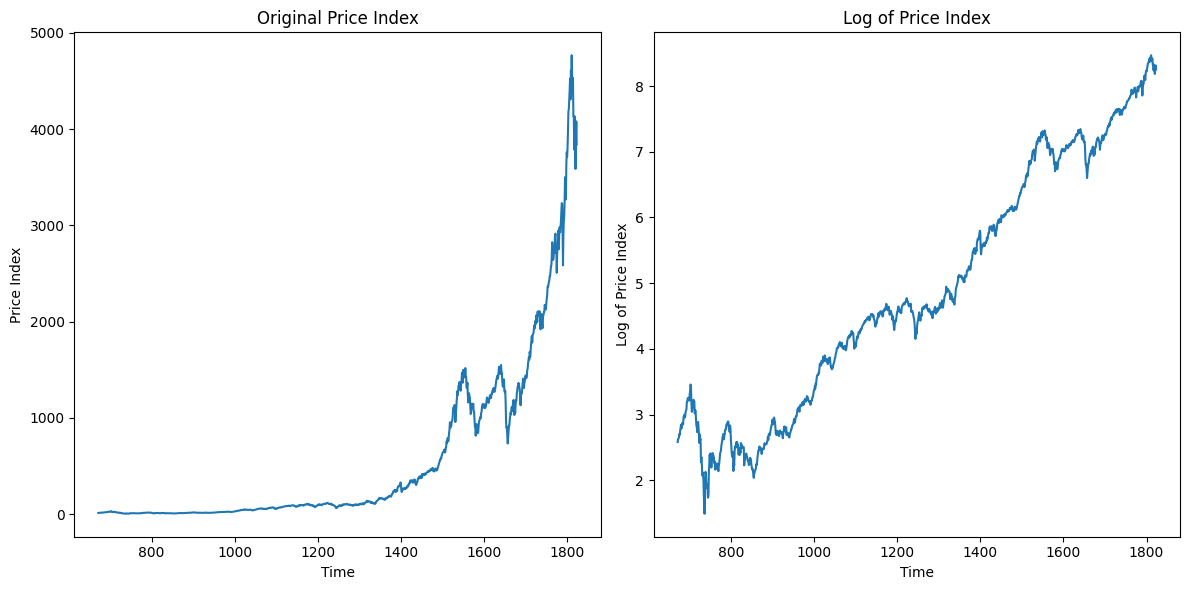

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(sp500_df_filtered['index'])
plt.title('Original Price Index')
plt.xlabel('Time')
plt.ylabel('Price Index')

plt.subplot(122)
plt.plot(sp500_df_filtered['logindex'])
plt.title('Log of Price Index')
plt.xlabel('Time')
plt.ylabel('Log of Price Index')

plt.tight_layout()
plt.show()


### Feature selection: Random Forest

In [ ]:
#load the clean data
sp500_df_filtered = pd.read_csv(path_out_ + 'sp500_clean.csv')

In [ ]:
features = ['dp', 'svar', 'bm','dp_lag1', 'dp_lag2',
       'dp_lag3', 'dp_lag4', 'svar_lag1', 'svar_lag2', 'svar_lag3',
       'svar_lag4', 'bm_lag1', 'bm_lag2', 'bm_lag3', 'bm_lag4',
        'logindex_lag1', 'logindex_lag2', 'logindex_lag3', 'logindex_lag4',
       'logret_lag1', 'logret_lag2', 'logret_lag3', 'logret_lag4',
       'direction_lag1', 'direction_lag2', 'direction_lag3', 'direction_lag4']

#prepare the data
train_data = sp500_df_filtered[sp500_df_filtered['date'] < '2018-01-01']
test_data = sp500_df_filtered[(sp500_df_filtered['date'] >= '2018-01-01') & (sp500_df_filtered['date'] <= '2021-12-31')]

X_train = train_data[features]
Y_train = {
    'logindex': train_data['logindex'],
    'logret': train_data['logret'],
    'direction': train_data['direction']
}

# since direction is binary, we define the model types for each target type
model_types = {
    'logret': RandomForestRegressor,
    'logindex': RandomForestRegressor,
    'direction': RandomForestClassifier
}

n_estimators = 100
top_n = 7
feature_importances = {}
top_features = {}

for target, y_train in Y_train.items():
    valid_idx = y_train.notna()
    model = model_types[target](n_estimators=n_estimators, random_state=42)
    model.fit(X_train[valid_idx], y_train[valid_idx])

    # Store and sort feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_importances[target] = importances
    top_features[target] = X_train.columns[indices[:top_n]]

    print(f"Top {top_n} important features for {target}:", top_features[target])

Top 7 important features for logindex: Index(['logindex_lag1', 'logindex_lag2', 'logindex_lag3', 'logindex_lag4',
       'bm', 'dp', 'dp_lag1'],
      dtype='object')
Top 7 important features for logret: Index(['svar', 'bm_lag2', 'dp', 'svar_lag1', 'logret_lag3', 'svar_lag2',
       'logret_lag2'],
      dtype='object')
Top 7 important features for direction: Index(['svar', 'dp', 'bm', 'logret_lag1', 'svar_lag1', 'dp_lag1',
       'logret_lag2'],
      dtype='object')


### Model 1: Gaussian Process

#### GridSearch CV & Prediction -Continuous Targets



In [ ]:
targets = ['logindex', 'logret']

sp500_df_filtered['date'] = pd.to_datetime(sp500_df_filtered['date'])
train_data = sp500_df_filtered[sp500_df_filtered['date'] < '2018-01-01']
#test_data = sp500_df_filtered[(sp500_df_filtered['date'] >= '2018-01-01') & (sp500_df_filtered['date'] <= '2021-12-31')]

In [ ]:
top_features_cont = {key: top_features[key] for key in targets}

print(top_features_cont)

{'logindex': Index(['logindex_lag1', 'logindex_lag2', 'logindex_lag3', 'logindex_lag4',
       'bm', 'dp', 'dp_lag1'],
      dtype='object'), 'logret': Index(['svar', 'bm_lag2', 'dp', 'svar_lag1', 'logret_lag3', 'svar_lag2',
       'logret_lag2'],
      dtype='object')}


In [ ]:
#gridsearch for continuous targets
models = {}
pred_gp = {}
performance_metrics = {}

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

#loop to perform a gridsearch for each target variable and predict
for target, features in top_features_cont.items():
    # Prepare feature matrix and target vector
    X_train = train_data[list(features)]
    y_train = train_data[target]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)  # Scale the features

    #diffkernels
    white_kernel = WhiteKernel(noise_level=0.5)
    constant_kernel = ConstantKernel(1.0)
    rbf_kernel = constant_kernel * RBF(length_scale=1) + white_kernel
    matern_kernel = constant_kernel * Matern(length_scale=1.0, nu=1.5)
    rq_kernel = RationalQuadratic(length_scale=1.0, alpha=1.5)
    dot_product_kernel = DotProduct(sigma_0=1)

    kernel_options = [rbf_kernel, dot_product_kernel, matern_kernel, rq_kernel]

    param_grid = {
        'kernel': kernel_options,
        'alpha': [1e-4]
    }
    gp = GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=20, random_state=0)

    grid_search = GridSearchCV(estimator=gp,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              cv = tscv)

    grid_search.fit(X_scaled, y_train)

    # Store results and best model
    models[target] = grid_search.best_estimator_

    print(f"Best parameters for {target}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {target}: {grid_search.best_score_}")

    # Transform test data using the same scaler fitted on the training data
    X_test = test_data[list(features)]
    X_test_scaled = scaler.transform(X_test)

    # Make predictions on test data
    pred_gp[target] = models[target].predict(X_test_scaled)
    test_data[f'{target}_gp_pred'] = pred_gp[target]

    # Calculate performance metrics
    mse = mean_squared_error(test_data[target], pred_gp[target])
    mae = mean_absolute_error(test_data[target], pred_gp[target])
    r2 = r2_score(test_data[target], pred_gp[target])

    performance_metrics[target] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

    print(f"Performance for {target}:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")
    print(f"  R-squared: {r2}")


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Best parameters for logindex: {'alpha': 0.0001, 'kernel': DotProduct(sigma_0=1)}
Best cross-validation score for logindex: -0.0002723967495913255
Performance for logindex:
  Mean Squared Error: 2.2860275001617027e-05
  Mean Absolute Error: 0.0033648690556540664
  R-squared: 0.9993160073108529


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessin

Best parameters for logret: {'alpha': 0.0001, 'kernel': RationalQuadratic(alpha=1.5, length_scale=1)}
Best cross-validation score for logret: -0.0017838834807601112
Performance for logret:
  Mean Squared Error: 0.0018179357997441692
  Mean Absolute Error: 0.03258336580335385
  R-squared: 0.24640883701802185


<ipython-input-43-347a8832f118>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'{target}_gp_pred'] = pred_gp[target]


#### GridSearch CV - Direction

In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
target = 'direction'
#gridsearch for binary target
features = top_features['direction']
X_train = train_data[features]
y_train = train_data['direction'].astype(int)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

#diffkernels
white_kernel = WhiteKernel(noise_level=0.5)
constant_kernel = ConstantKernel(1.0)
rbf_kernel = constant_kernel * RBF(length_scale=1) + white_kernel
matern_kernel = constant_kernel * Matern(length_scale=1.0, nu=1.5)
rq_kernel = RationalQuadratic(length_scale=1.0, alpha=1.5)
dot_product_kernel = DotProduct(sigma_0=1)

kernel_options = [rbf_kernel, dot_product_kernel, matern_kernel, rq_kernel]

param_grid = {
    'kernel': kernel_options,
    'max_iter_predict': [500, 1000],
}

gp_classifier = GaussianProcessClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gp_classifier, param_grid=param_grid, scoring='roc_auc', cv=tscv, verbose=1)
grid_search.fit(X_scaled, y_train)

models[target]= grid_search.best_estimator_
print(f"Best parameters for direction: {grid_search.best_params_}")
print(f"Best cross-validation score for direction: {grid_search.best_score_}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420:

Best parameters for direction: {'kernel': DotProduct(sigma_0=1), 'max_iter_predict': 500}
Best cross-validation score for direction: 0.9575755607061677


#### Predictions - Direction

In [ ]:
X_test = test_data[features]
X_test_scaled = scaler.transform(X_test)

#class labels for the test set
pred_gp_dir = models[target].predict(X_test_scaled)
#probability estimates for the binary classes
pred_gp_dir_prob = models[target].predict_proba(X_test_scaled)

true_labels = test_data['direction'].astype(int)

test_data[f'direction_gp_pred'] = pred_gp_dir
test_data[f'direction_gp_pred_prob']= pred_gp_dir_prob[:, 1]

# Calculate performance metrics
roc_auc = roc_auc_score(test_data[target].dropna(), test_data[f'{target}_gp_pred_prob'])
accuracy = accuracy_score(test_data[target], test_data[f'{target}_gp_pred'])
logloss = log_loss(test_data[target], test_data[f'{target}_gp_pred_prob'])

performance_metrics[target] = {
    'ROC_AUC': roc_auc,
    'Accuracy': accuracy,
    'Log Loss': logloss
}

print(f"Performance for {target}:")
print(f"  ROC AUC: {roc_auc}")
print(f"  Accuracy: {accuracy}")
print(f"  Log Loss: {logloss}")

Performance for direction:
  ROC AUC: 0.9978991596638656
  Accuracy: 0.9375
  Log Loss: 0.3305283491332704


<ipython-input-51-82b26ab63cbf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'direction_gp_pred'] = pred_gp_dir
<ipython-input-51-82b26ab63cbf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'direction_gp_pred_prob']= pred_gp_dir_prob[:, 1]


### Model 2: NNET

#### GridSearch CV & Prediction -Continuous Targets


In [ ]:
#gridsearch & prediction for price and return
tscv = TimeSeriesSplit(n_splits=5)
models_nn = {}
pred_nn = {}
performance_metricsnn = {}

#loop to perform a gridsearch for each target variable and predict
for target, features in top_features_cont.items():
    X_train = train_data[list(features)]
    y_train = train_data[target]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    param_grid = {
        'hidden_layer_sizes': [(20,), (20, 20), (50,), (100,), (100, 100), (50, 50), (100, 50, 25)],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.0001, 0.001]
    }

    mlp = MLPRegressor(max_iter=10000,
                      random_state=42,
                      verbose=True,
                      early_stopping=True,
                      validation_fraction=0.1)

    grid_search = GridSearchCV(mlp, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_scaled, y_train)

    models_nn[target] = grid_search.best_estimator_

    print(f"Best parameters for {target}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {target}: {grid_search.best_score_}")

    X_test = test_data[list(features)]
    X_test_scaled = scaler.transform(X_test)

    pred_nn[target] = models_nn[target].predict(X_test_scaled)
    test_data[f'{target}_nn_pred'] = pred_nn[target]

    mse = mean_squared_error(test_data[target], pred_nn[target])
    mae = mean_absolute_error(test_data[target], pred_nn[target])
    r2 = r2_score(test_data[target], pred_nn[target])

    performance_metricsnn[target] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

    print(f"Performance for {target}:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")
    print(f"  R-squared: {r2}")

Iteration 1, loss = 15.83492497
Validation score: -9.236365
Iteration 2, loss = 14.35552982
Validation score: -8.240949
Iteration 3, loss = 12.96076463
Validation score: -7.307348
Iteration 4, loss = 11.68267559
Validation score: -6.434107
Iteration 5, loss = 10.46342939
Validation score: -5.627346
Iteration 6, loss = 9.33796708
Validation score: -4.884892
Iteration 7, loss = 8.29672250
Validation score: -4.205753
Iteration 8, loss = 7.35795569
Validation score: -3.583655
Iteration 9, loss = 6.49031130
Validation score: -3.018644
Iteration 10, loss = 5.70065143
Validation score: -2.507753
Iteration 11, loss = 4.98838820
Validation score: -2.047391
Iteration 12, loss = 4.34080865
Validation score: -1.635451
Iteration 13, loss = 3.76297584
Validation score: -1.267716
Iteration 14, loss = 3.25041575
Validation score: -0.940731
Iteration 15, loss = 2.78296790
Validation score: -0.653965
Iteration 16, loss = 2.37648206
Validation score: -0.402238
Iteration 17, loss = 2.02282471
Validation s

#### Gridsearch CV - Direction

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 100),(50, 50), (100, 50, 25)],
    'activation': ['sigmoid', 'softmax', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.0001, 0.001]
}

target = 'direction'
features = top_features[target]

X_train = train_data[list(features)]
y_train = train_data[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

mlp = MLPClassifier(max_iter=10000,
                   random_state=42,
                   verbose=True,
                   early_stopping=True,
                   validation_fraction=0.1)

grid_search_nn_dir = GridSearchCV(mlp, param_grid, cv=tscv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_nn_dir.fit(X_scaled, y_train.dropna())

models_nn[target] = grid_search_nn_dir.best_estimator_

print(f"Best parameters for {target}: {grid_search_nn_dir.best_params_}")
print(f"Best cross-validation score for {target}: {grid_search_nn_dir.best_score_}")


Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
320 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
86 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 747, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist

Iteration 1, loss = 0.67438389
Validation score: 0.563636
Iteration 2, loss = 0.65989663
Validation score: 0.554545
Iteration 3, loss = 0.65141610
Validation score: 0.563636
Iteration 4, loss = 0.64491167
Validation score: 0.554545
Iteration 5, loss = 0.63839459
Validation score: 0.563636
Iteration 6, loss = 0.63244300
Validation score: 0.563636
Iteration 7, loss = 0.62570488
Validation score: 0.581818
Iteration 8, loss = 0.61981556
Validation score: 0.581818
Iteration 9, loss = 0.61341711
Validation score: 0.581818
Iteration 10, loss = 0.60768433
Validation score: 0.618182
Iteration 11, loss = 0.60039675
Validation score: 0.627273
Iteration 12, loss = 0.59372110
Validation score: 0.627273
Iteration 13, loss = 0.58685272
Validation score: 0.636364
Iteration 14, loss = 0.57944173
Validation score: 0.654545
Iteration 15, loss = 0.57181765
Validation score: 0.654545
Iteration 16, loss = 0.56365965
Validation score: 0.645455
Iteration 17, loss = 0.55381996
Validation score: 0.663636
Iterat

#### Predictions - Direction

In [ ]:
#logret preds with NN
X_test = test_data[list(features)]
x_test_scaled = scaler.transform(X_test)

pred_nn[target] = models_nn[target].predict(X_test_scaled)
test_data[f'{target}_nn_pred'] = pred_nn[target]

pred_nn_dir_prob = models_nn[target].predict_proba(x_test_scaled)
test_data[f'{target}_nn_prob'] = pred_nn_dir_prob[:, 1]

# Calculate performance metrics
roc_auc = roc_auc_score(test_data[target].dropna(), test_data[f'{target}_nn_prob'])
accuracy = accuracy_score(test_data[target], test_data[f'{target}_nn_pred'])
logloss = log_loss(test_data[target], test_data[f'{target}_nn_prob'])

performance_metricsnn[f'{target}_nn'] = {
    'ROC_AUC': roc_auc,
    'Accuracy': accuracy,
    'Log Loss': logloss
}

print(f"Performance for {target}:")
print(f"  ROC AUC: {roc_auc}")
print(f"  Accuracy: {accuracy}")
print(f"  Log Loss: {logloss}")

Performance for direction:
  ROC AUC: 0.976890756302521
  Accuracy: 0.7083333333333334
  Log Loss: 0.2527270234033511


<ipython-input-49-18dd46e4fe9d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'{target}_nn_pred'] = pred_nn[target]
<ipython-input-49-18dd46e4fe9d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'{target}_nn_prob'] = pred_nn_dir_prob[:, 1]


In [ ]:
#save test data with the predctions
test_data.to_csv(path_out_ + 'pred_og.csv', index=False)

### Plotting Results

In [ ]:
test_data = pd.read_csv(path_out_ + 'pred.csv')

Before plotting, we convert the log of index back to index, so we can better visualize the predictions and metrics

In [ ]:
test_data['index_gp_pred'] = np.exp(test_data['logindex_gp_pred'])
test_data['index_nn_pred'] = np.exp(test_data['logindex_nn_pred'])

#### Metrics

In [ ]:
test_data[['index_gp_pred', 'index_nn_pred']].head()

,index_gp_pred,index_nn_pred
0,2817.444795,1921.176140
1,2718.222324,1961.939145
2,2643.252128,1954.335058
3,2648.730898,1946.149315
4,2702.234378,1945.349662


In [ ]:
test_data.columns

Index(['yyyymm', 'index', 'd12', 'e12', 'bm', 'tbl', 'aaa', 'baa', 'lty',
       'ntis', 'rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'crsp_spvw',
       'crsp_spvwx', 'date', 'dp', 'de', 'ep', 'dy', 'dfy', 'logret',
       'logindex', 'index_return', 'direction', 'dp_lag1', 'dp_lag2',
       'dp_lag3', 'dp_lag4', 'svar_lag1', 'svar_lag2', 'svar_lag3',
       'svar_lag4', 'bm_lag1', 'bm_lag2', 'bm_lag3', 'bm_lag4',
       'logindex_lag1', 'logindex_lag2', 'logindex_lag3', 'logindex_lag4',
       'logret_lag1', 'logret_lag2', 'logret_lag3', 'logret_lag4',
       'direction_lag1', 'direction_lag2', 'direction_lag3', 'direction_lag4',
       'logindex_gp_pred', 'logret_gp_pred', 'direction_gp_pred',
       'direction_gp_pred_prob', 'logindex_nn_pred', 'logret_nn_pred',
       'direction_nn_pred', 'direction_nn_prob'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


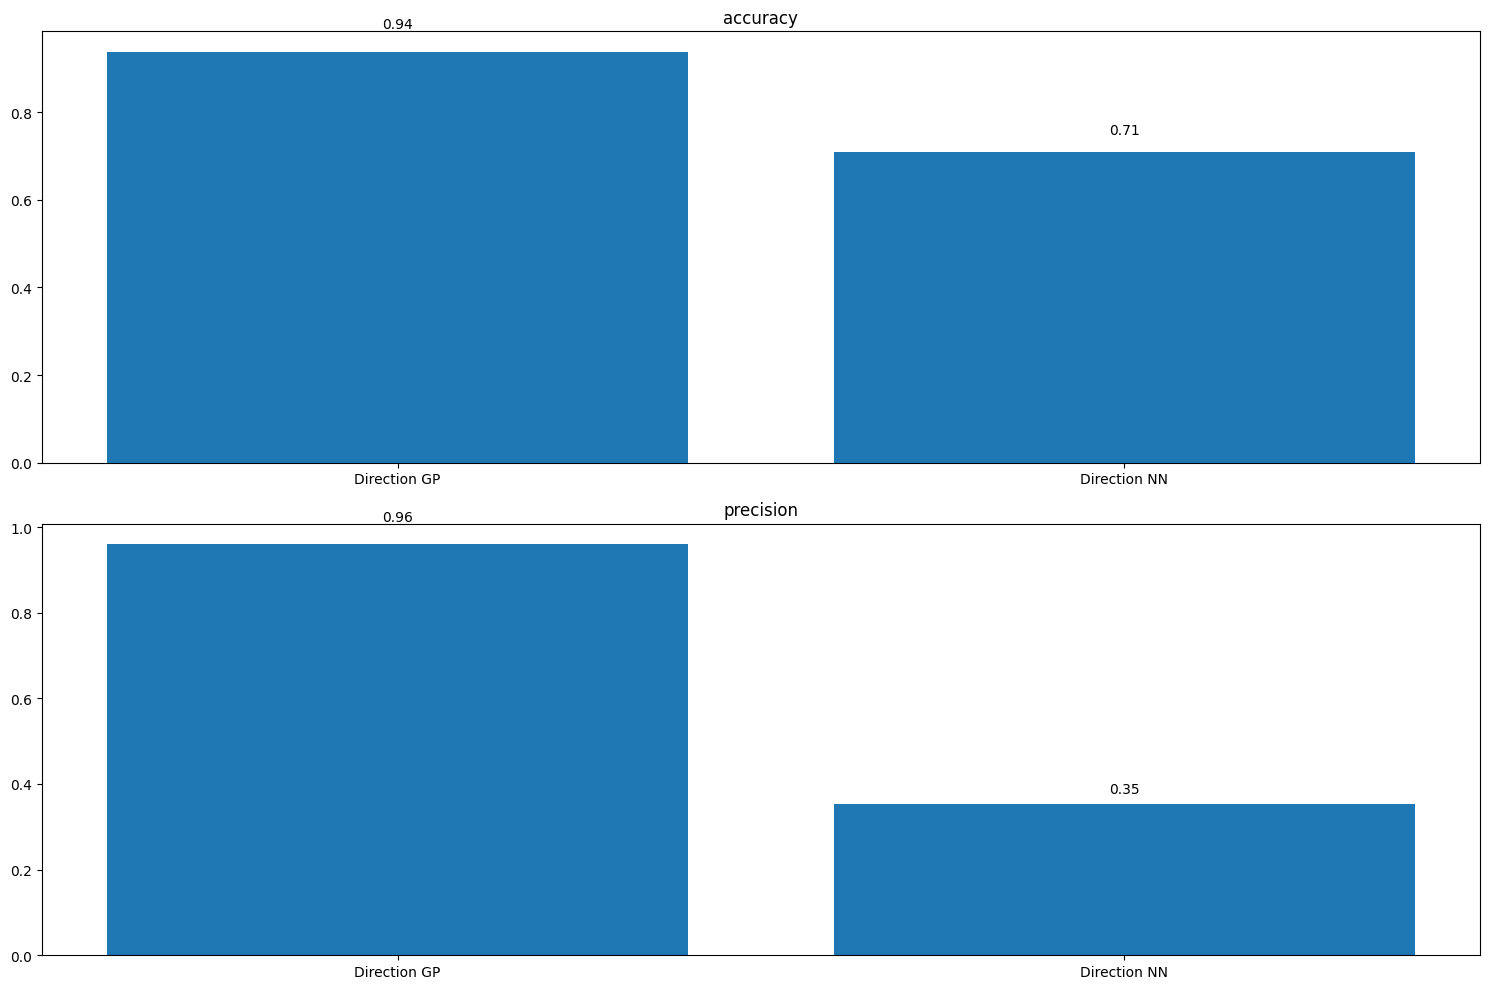

In [ ]:
#plot metrics for continuous targets: price and return
metrics_dir_val= Metrics()
metrics_dir_val.run(test_data['direction'], test_data['direction_gp_pred'], "Direction GP")
metrics_dir_val.run(test_data['direction'], test_data['direction_nn_pred'], "Direction NN")
metrics_dir_val.plot()

#### Logindex Plot

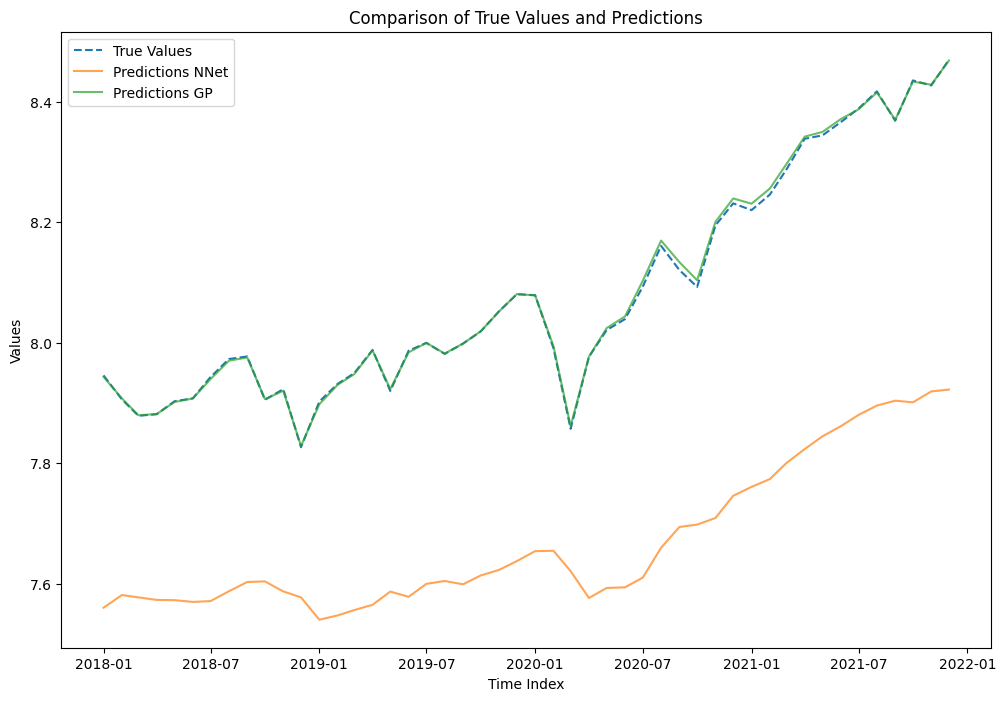

In [ ]:
# Evaluation of Results
df_logindex_res = pd.DataFrame(
    {'true': test_data['logindex'], 'pred_nn': pred_nn['logindex'], 'pred_gp': pred_gp['logindex']}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logindex_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logindex_res['date'] = pd.to_datetime(df_logindex_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logindex_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logindex_res['true'], label='True Values', linestyle='--')
plt.plot(df_logindex_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logindex_res['pred_gp'], label='Predictions GP', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()

#### Logret (Returns) Plot

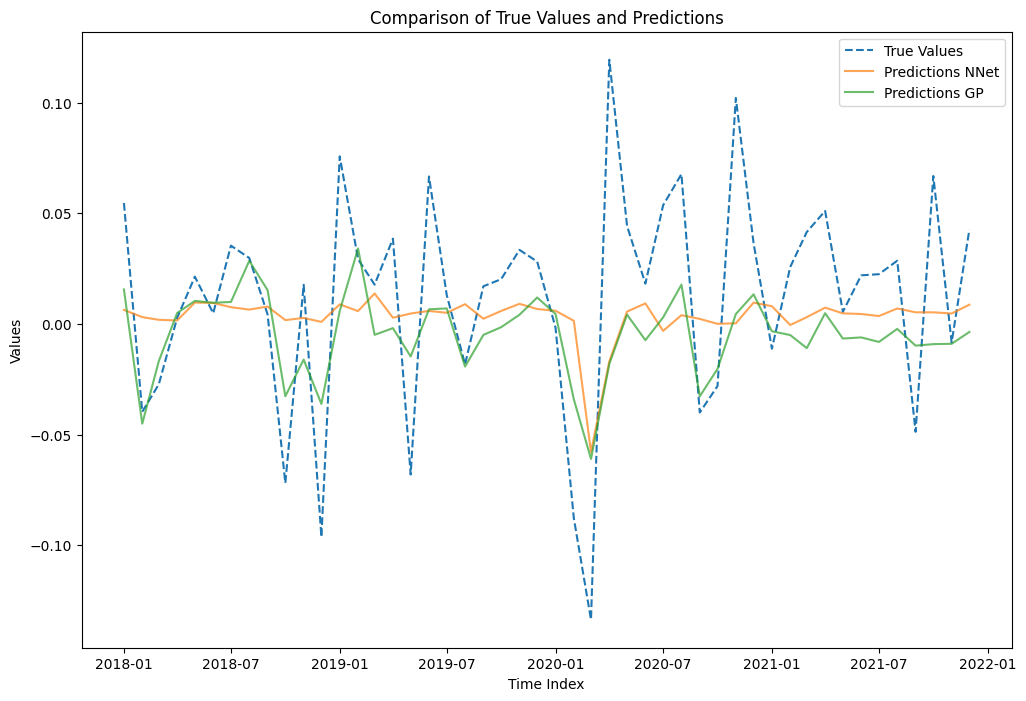

In [ ]:
# Evaluation of Results
df_logret_res = pd.DataFrame(
    {'true': test_data['logret'], 'pred_nn': pred_nn['logret'], 'pred_gp': pred_gp['logret']}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logret_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logret_res['date'] = pd.to_datetime(df_logret_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logret_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logret_res['true'], label='True Values', linestyle='--')
plt.plot(df_logret_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logret_res['pred_gp'], label='Predictions GP', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()


#### Direction Plot

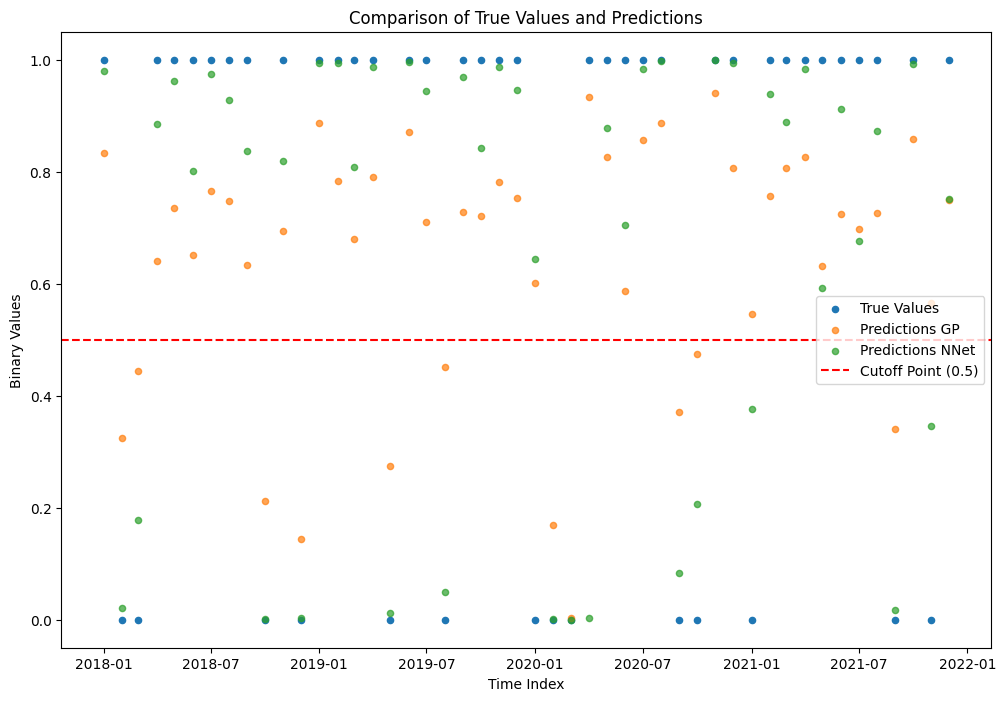

In [ ]:
# Evaluation of Results
df_direction_res = pd.DataFrame(
    {'true': test_data['direction'], 'pred_nn': test_data['direction_nn_prob'], 'pred_gp': test_data['direction_gp_pred_prob']}
)

df_direction_res['date'] = test_data.date
df_direction_res['date'] = pd.to_datetime(df_direction_res['date'])
df_direction_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))

# Plot True Values
plt.scatter(df_direction_res.index, df_direction_res['true'], label='True Values', marker='o', s=20)

# Plot Predictions for NNet and GP
plt.scatter(df_direction_res.index, df_direction_res['pred_gp'], label='Predictions GP', alpha=0.7, s=20)
plt.scatter(df_direction_res.index, df_direction_res['pred_nn'], label='Predictions NNet', alpha=0.7, s=20)

# Adding a horizontal line at y=0.5
plt.axhline(y=0.5, color='r', linestyle='--', label='Cutoff Point (0.5)')

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Binary Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()


## <a id='part4'>Part 4: Further Analysis</a>
- **Objective**: Discuss modeling aspects and compare methods.
- **Tasks:**
  - Create an ARMA model and compare to the neural network and gaussian process.
  - Discuss if bootstrapping would aid model performance and efficacy and what modeling would look like with the incorporation of stationary bootstrapping.

### Model 3: ARMA Model
Before we fit an ARMA model, we first check to see if the series is stationary

In [ ]:
logindex_df = sp500_df_filtered[['date', 'logindex']]
logret_df = sp500_df_filtered[['date','logret']]
direction_df = sp500_df_filtered[['date','direction']]

print(logret_df)

            date    logret
0     1927-01-01 -0.020975
1     1927-02-01  0.046589
2     1927-03-01  0.006482
3     1927-04-01  0.017082
4     1927-05-01  0.050905
...          ...       ...
1147  2022-08-01 -0.043367
1148  2022-09-01 -0.098049
1149  2022-10-01  0.076835
1150  2022-11-01  0.052358
1151  2022-12-01 -0.060782

[1152 rows x 2 columns]


<Axes: xlabel='date'>

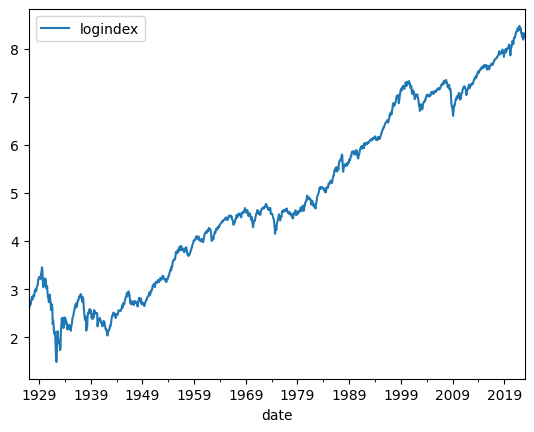

In [ ]:
logindex_df.plot(x="date", y="logindex")

In [ ]:
#function to test if the time series is stationary using the Augmented Dickey–Fuller test
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] > 0.05:
      print("Data is not stationary")
    else:
      print("Data is stationary")

In [ ]:
targets = ['logindex', 'logret', 'direction']
for target in targets:
  test_stationarity(sp500_df_filtered[target])

ADF Statistic: 0.6551436672311208
p-value: 0.9888988290720038
Critical Values:
	1%: -3.436150192101723
	5%: -2.8641011312034057
	10%: -2.5681336157882373
Data is not stationary
ADF Statistic: -8.092508431685243
p-value: 1.3662615637880084e-12
Critical Values:
	1%: -3.4361450520165464
	5%: -2.8640988637413893
	10%: -2.5681324081722314
Data is stationary
ADF Statistic: -12.79841838220568
p-value: 6.83650539998581e-24
Critical Values:
	1%: -3.436064032324827
	5%: -2.864063122757945
	10%: -2.5681133731450605
Data is stationary


If the ADF statistic is more negative than these critical values, the null hypothesis can be rejected with the corresponding confidence level. In our case, the ADF statistic of 4.360936254804394 is not more negative than any of the critical values, confirming that the time series can be considered to have a unit root and is non-stationary at the 1%, 5%, and 10% levels.

Index is not stationary, logret and direction are stationary

Since index is not stationary, we will use differencing to stabalize them

In [ ]:
logindex_df['difflogindex'] = logindex_df['logindex'].diff()
logindex_df.dropna(inplace=True)

test_stationarity(logindex_df['difflogindex'])

ADF Statistic: -8.09135011871243
p-value: 1.3755641693941708e-12
Critical Values:
	1%: -3.436150192101723
	5%: -2.8641011312034057
	10%: -2.5681336157882373
Data is stationary


<ipython-input-41-bb34d725f743>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logindex_df['difflogindex'] = logindex_df['logindex'].diff()
<ipython-input-41-bb34d725f743>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logindex_df.dropna(inplace=True)


Now we use the auto_arima function from the pmdarima library to determine the best parameters for an ARIMA model

In [ ]:
#function to find the best parameters for the arma model, generate predictons and calculate metrics
def train_evaluate_arima(df, start_date, end_date, target):
    train = df[df['date'] < start_date]
    test = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    y_train = train[['date', target]]
    y_test = test[['date', target]]

    y_train.set_index('date', inplace=True)
    y_test.set_index('date', inplace=True)

    model = auto_arima(y_train, seasonal=True, error_action='ignore', suppress_warnings=True, stepwise=True, trace=True)
    pred_arma = model.predict(n_periods=len(y_test)) #predict

    # Align predictions with the test index dates for comparison and metrics calculation
    y_test['pred_arma'] = pred_arma

    # Calculate performance metrics
    mse = mean_squared_error(y_test[target], y_test['pred_arma'])
    mae = mean_absolute_error(y_test[target], y_test['pred_arma'])
    r2 = r2_score(y_test[target], y_test['pred_arma'])

    # Print performance metrics
    performance_metrics_arma = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

    print(f"Performance metrics:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")
    print(f"  R-squared: {r2}")

    return model, performance_metrics_arma, y_test

In [ ]:
#run for logindexdiff
model_index, metrics_index, index_predictions = train_evaluate_arima(logindex_df, '2018-01-01', '2021-12-31', 'difflogindex')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3281.494, Time=1.45 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3262.219, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3267.232, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3267.479, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3255.443, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3264.346, Time=1.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3265.257, Time=0.88 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-3276.556, Time=1.46 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-3280.234, Time=1.37 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3265.491, Time=0.28 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-3270.560, Time=1.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-3269.755, Time=1.28 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-3277.542, Time=1.51 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3275.672, Time=0.65 sec

Best model:  ARIMA

<ipython-input-42-416250510282>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred_arma'] = pred_arma


Convert the values back to original scale so i can compare with other model's results

In [ ]:
# Step 1: Get the last actual known value from the original data
last_known_value = logindex_df['logindex'].iloc[-len(index_predictions['pred_arma'])-1]

# Step 2: Cumulatively sum the predictions and add the last known value
restored_predictions = index_predictions['pred_arma'].cumsum() + last_known_value

# Optional Step 3: Append the last known value to the beginning if needed for alignment
restored_predictions = pd.concat([pd.Series([last_known_value], index=[logindex_df.index[-len(index_predictions)-1]]), restored_predictions])


In [ ]:
# Dropping the first row of the series
restored_predictions = restored_predictions[1:]
restored_predictions

2018-01-01    7.833524
2018-02-01    7.840779
2018-03-01    7.843311
2018-04-01    7.847308
2018-05-01    7.854270
2018-06-01    7.858974
2018-07-01    7.862340
2018-08-01    7.867921
2018-09-01    7.873638
2018-10-01    7.877642
2018-11-01    7.882215
2018-12-01    7.887849
2019-01-01    7.892641
2019-02-01    7.896967
2019-03-01    7.902107
2019-04-01    7.907277
2019-05-01    7.911826
2019-06-01    7.916595
2019-07-01    7.921744
2019-08-01    7.926578
2019-09-01    7.931252
2019-10-01    7.936224
2019-11-01    7.941200
2019-12-01    7.945950
2020-01-01    7.950786
2020-02-01    7.955757
2020-03-01    7.960612
2020-04-01    7.965411
2020-05-01    7.970318
2020-06-01    7.975225
2020-07-01    7.980051
2020-08-01    7.984909
2020-09-01    7.989816
2020-10-01    7.994679
2020-11-01    7.999523
2020-12-01    8.004406
2021-01-01    8.009289
2021-02-01    8.014142
2021-03-01    8.019008
2021-04-01    8.023891
2021-05-01    8.028757
2021-06-01    8.033617
2021-07-01    8.038492
2021-08-01 

In [ ]:
#run for logret
model_logret, metrics_logret, logret_predictions = train_evaluate_arima(logret_df, '2018-01-01', '2021-12-31', 'logret')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3284.885, Time=1.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3265.986, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3270.941, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3271.186, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3259.280, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3268.065, Time=1.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3267.565, Time=0.55 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-3283.878, Time=1.80 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-3283.989, Time=1.83 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3269.201, Time=0.82 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-3274.278, Time=1.59 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-3273.472, Time=1.18 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-3281.269, Time=1.74 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3279.460, Time=0.66 sec

Best model:  ARIMA

In [ ]:
restored_predictions

,date,0
0,2018-01-01,7.833524
1,2018-02-01,7.840779
2,2018-03-01,7.843311
3,2018-04-01,7.847308
4,2018-05-01,7.854270
5,2018-06-01,7.858974
6,2018-07-01,7.862340
7,2018-08-01,7.867921
8,2018-09-01,7.873638
9,2018-10-01,7.877642


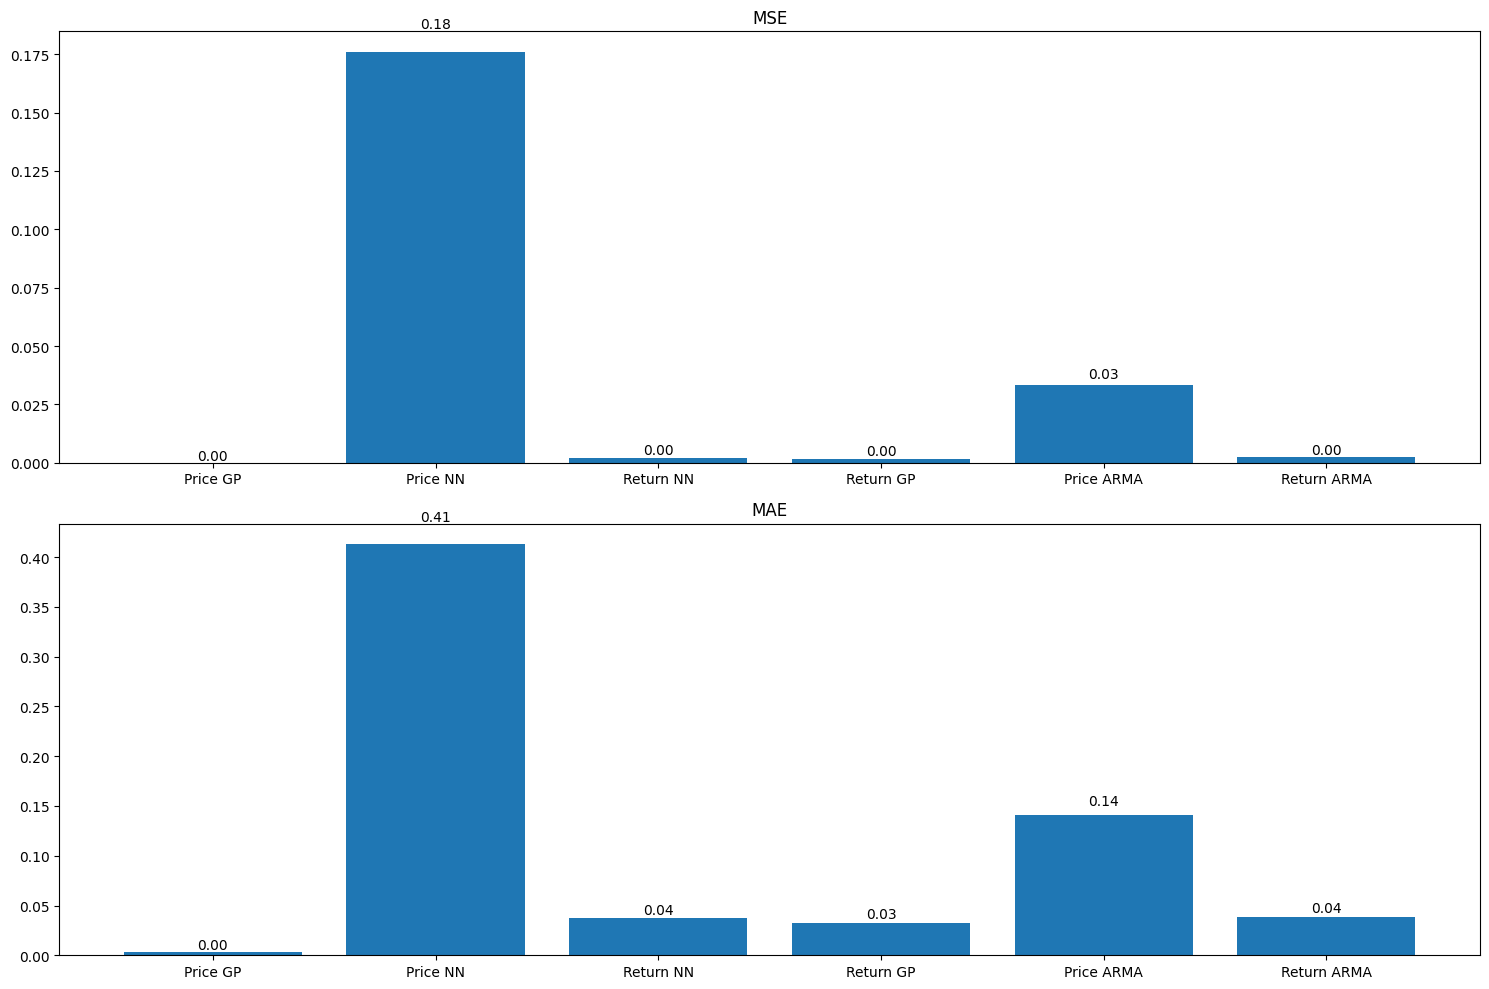

In [ ]:
#craeting a new df with the true values for logindex
logindex_df_test = logindex_df[(logindex_df['date'] >= '2018-01-01') & (logindex_df['date'] <= '2021-12-31')]
metrics_val.run(logindex_df_test['logindex'], restored_predictions[0], "Price ARMA")
metrics_val.run(logret_predictions['logret'], logret_predictions['pred_arma'], "Return ARMA")
metrics_val.plot()

In [ ]:
# Convert 'date' in test_data
test_data['date'] = pd.to_datetime(test_data['date'])
logret_predictions = logret_predictions.reset_index().rename(columns={'index': 'date'})
logret_predictions['date'] = pd.to_datetime(logret_predictions['date'])  # Adjust 'unit' as necessary

### Plots results

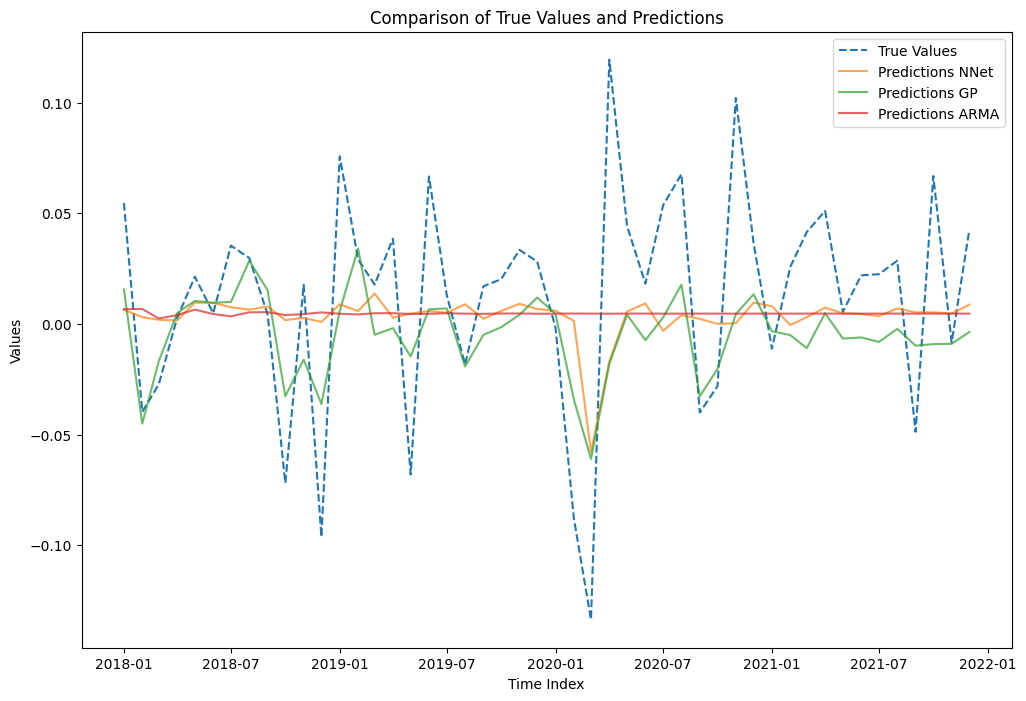

In [ ]:
#Compare ARMA model to NN and Gaussian Process Regression
# Evaluation of Results
df_logret_res = pd.DataFrame(
    {'true': test_data['logret'], 'pred_nn': test_data['logret_nn_pred'], 'pred_gp': test_data['logret_gp_pred'], 'pred_arma': logret_predictions['pred_arma']}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logret_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logret_res['date'] = pd.to_datetime(df_logret_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logret_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logret_res['true'], label='True Values', linestyle='--')
plt.plot(df_logret_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logret_res['pred_gp'], label='Predictions GP', alpha=0.7)
plt.plot(df_logret_res['pred_arma'], label='Predictions ARMA', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()

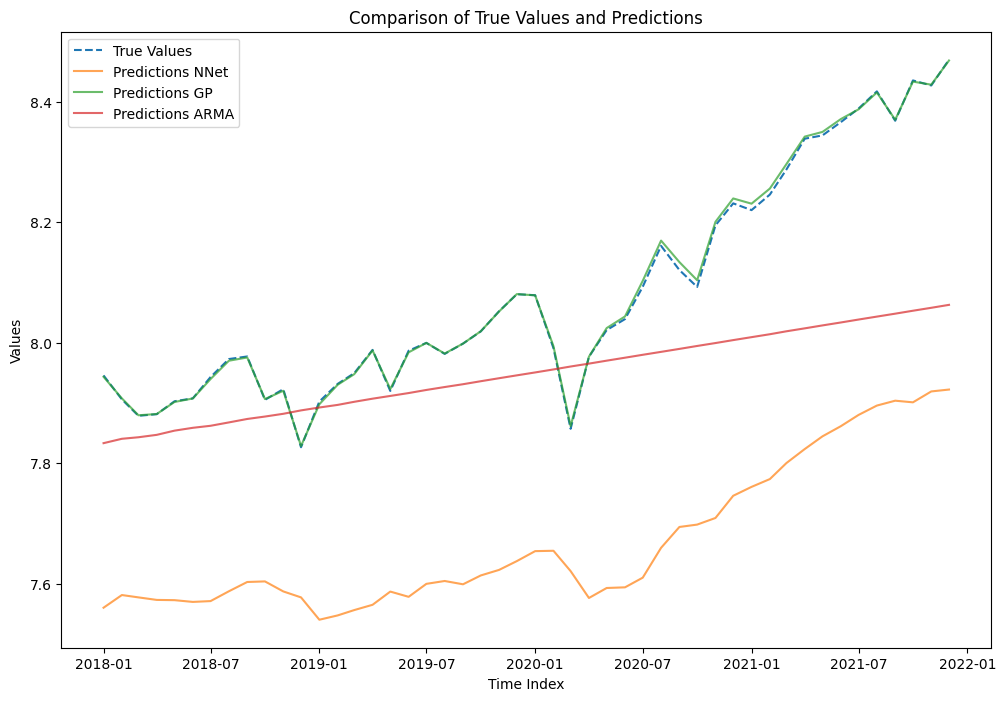

In [ ]:
# Convert 'date' in test_data
#test_data['date'] = pd.to_datetime(test_data['date'])
restored_predictions = restored_predictions.reset_index().rename(columns={'index': 'date'})
restored_predictions['date'] = pd.to_datetime(restored_predictions['date'])  # Adjust 'unit' as necessary

# Evaluation of Results
df_logindex_res = pd.DataFrame(
    {'true': test_data['logindex'], 'pred_nn': test_data['logindex_nn_pred'], 'pred_gp': test_data['logindex_gp_pred'], 'pred_arma': restored_predictions[0]}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logindex_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logindex_res['date'] = pd.to_datetime(df_logindex_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logindex_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logindex_res['true'], label='True Values', linestyle='--')
plt.plot(df_logindex_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logindex_res['pred_gp'], label='Predictions GP', alpha=0.7)
plt.plot(df_logindex_res['pred_arma'], label='Predictions ARMA', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
#Stationary Bootstrapping


In [ ]:
#Modeling with Stationary Bootstrapping (if necessary)
